# Kosmetyki męskie - część III - EDA

### Wstęp

Prezentowane na tej stronie materiały są zapisem trzeciego etapu projektu "Kosmetyki męskie".

Opis projektu:

I etap (pobranie danych):

II etap (Preprocessing):

Dane z drugiego etapu projektu zostały zapisane jako *Data Frame* w pliku .pkl (*pickle*) - male_data_preprocessed.pkl.

Celem tego etapu jest dogłębna eksploracja poprzedzająca proces modelowania statystycznego i uczenia maszynowego. Efektem tego etapu będzie wybór danych do ostatecznych analiz i modelowania.

#### Pobranie niezbędnych bibliotek

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from collections import Counter

#### Pobranie danych

In [77]:
df = pd.read_pickle('../data/male_data_preprocessed.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 0 to 1793
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     1482 non-null   int64  
 1   name                           1482 non-null   string 
 2   caption                        1482 non-null   string 
 3   cat_1                          1482 non-null   string 
 4   cat_2                          1482 non-null   string 
 5   cat_3                          1482 non-null   string 
 6   cat_4                          1482 non-null   string 
 7   cat_5                          1482 non-null   string 
 8   url                            1482 non-null   string 
 9   current_price_pln              1482 non-null   float64
 10  regular_price_pln              146 non-null    float64
 11  lowest_price_last_30_days_pln  433 non-null    float64
 12  mega_badge                     1482 non-null   bool  

#### Lista kategorii najwyższego poziomu

In [78]:
last_category = df['cat_5'].combine_first(df['cat_4']).combine_first(df['cat_3']).combine_first(df['cat_2'])
categories = (
    last_category.dropna()
    .explode()
    .str.strip()
)

set(categories)

{''}

#### Wyciągnięcie marki do oddzielnej kolumny

In [79]:
# Ten sposob zwraca niepełne nazwy
#df['brand'] = df['name'].str.split(' ').str[0]
#df['brand'].unique()

def extract_brand(name):
    words = name.split()
    brand_words = []
    for w in words:
        if re.fullmatch(r'[A-Z0-9\-&!]+', w):
            brand_words.append(w)
        else:
            break
    
    return " ".join(brand_words) if brand_words else words[0]

df['brand'] = df['name'].apply(extract_brand)
df['brand'].unique()

array(['RITUALS...', 'JAGUAR', 'HUGO BOSS', 'EVELINE COSMETICS',
       'BENTLEY', 'NIVEA MEN', 'REXONA MEN', 'BUGATTI', 'SWISS ARABIAN',
       'BRISK', 'VICTORIO & LUCCHINO', 'POLICE', 'ADIDAS', 'DOVE',
       'TOM FORD', 'TOŁPA', 'BANDERAS', 'MONT BLANC', 'ARMAF', 'ICEBERG',
       "L'ORÉAL", 'BURBERRY', 'MEXX', 'PHLOV', 'LACOSTE',
       'SCHWARZKOPF MEN', 'GILLETTE', 'PEPE JEANS', 'YVES SAINT LAURENT',
       'LOEWE', 'TRUSSARDI', "ADOPT'", 'GOLDWELL', 'CLEANHANDS',
       'ARGANOVE', 'JOOP!', 'RASASI', 'PACO RABANNE', 'ISANA MEN',
       'WILKINSON SWORD', 'DAVID BECKHAM', 'SCHWARZKOPF PROFESSIONAL',
       'HAGI', 'PACO RABANNE XS', 'ZIAJA', 'LAQ', 'FILA', 'GUY LAROCHE',
       'AA MEN', 'GUESS', 'VERSACE', 'HERMES', 'JEAN PAUL GAULTIER',
       'OLD SPICE', 'STR8', 'AZZARO', 'HERMES H24', 'MASVERI', 'LA RIVE',
       'ABERCROMBIE & FITCH', 'BOND', 'SCHWARZKOPF TAFT', 'SYOSS',
       'ALTERRA', 'CRISTIANO RONALDO CR7', 'NIKE', 'BERANI', 'GUERLAIN',
       'CAROLINA HERRERA 212',

In [80]:
# Niektóre marki są powielone
# Mapa duplikatów
brand_map = {
    # HUGO BOSS
    "HUGO BOSS XY": "HUGO BOSS",

    # PACO RABANNE
    "PACO RABANNE XS": "PACO RABANNE",
    "PACO RABANNE 1": "PACO RABANNE",

    # CAROLINA HERRERA
    "CAROLINA HERRERA 212": "CAROLINA HERRERA",
    "CAROLINA HERRERA 212 VIP": "CAROLINA HERRERA",

    # SCHWARZKOPF i warianty
    "SCHWARZKOPF MEN": "SCHWARZKOPF",
    "SCHWARZKOPF PROFESSIONAL": "SCHWARZKOPF",
    "SCHWARZKOPF PROFESSIONAL SILHOUETTE": "SCHWARZKOPF",
    "SCHWARZKOPF TAFT": "SCHWARZKOPF",
    "SCHWARZKOPF RE-NATURE": "SCHWARZKOPF",

    # LOEWE
    "LOEWE 7": "LOEWE",
    "LOEWE 001": "LOEWE",

    # ISANA
    "ISANA MEN": "ISANA",

    # ADIDAS
    "ADIDAS UEFA": "ADIDAS",

    # YVES SAINT LAURENT
    "YVES SAINT LAURENT Y": "YVES SAINT LAURENT",

    # LA RIVE
    "LA RIVE 315": "LA RIVE",

    # SORVELLA
    "SORVELLA CRD": "SORVELLA",
    "SORVELLA S-612": "SORVELLA",
    "SORVELLA S-627": "SORVELLA",
    "SORVELLA S-530": "SORVELLA",
    "SORVELLA S-526": "SORVELLA",
    "SORVELLA S-656": "SORVELLA",

    # AA MEN i AA
    "AA MEN": "AA",
    
    # DOLCE & GABBANA
    "DOLCE & GABBANA K": "DOLCE & GABBANA",

    # SCHOLL
    "DR.SCHOLL'S": "SCHOLL",

    # CALVIN KLEIN
    "CALVIN KLEIN CK IN2U": "CALVIN KLEIN",

    # JANDA
    "JANDA GENTLEMAN": "JANDA",

    # BIELENDA
    "BIELENDA PROFESSIONAL": "BIELENDA",
}

def simplify_brand(brand):
    return brand_map.get(brand, brand)

df["brand"] = df["brand"].apply(simplify_brand)
df['brand'].unique()

array(['RITUALS...', 'JAGUAR', 'HUGO BOSS', 'EVELINE COSMETICS',
       'BENTLEY', 'NIVEA MEN', 'REXONA MEN', 'BUGATTI', 'SWISS ARABIAN',
       'BRISK', 'VICTORIO & LUCCHINO', 'POLICE', 'ADIDAS', 'DOVE',
       'TOM FORD', 'TOŁPA', 'BANDERAS', 'MONT BLANC', 'ARMAF', 'ICEBERG',
       "L'ORÉAL", 'BURBERRY', 'MEXX', 'PHLOV', 'LACOSTE', 'SCHWARZKOPF',
       'GILLETTE', 'PEPE JEANS', 'YVES SAINT LAURENT', 'LOEWE',
       'TRUSSARDI', "ADOPT'", 'GOLDWELL', 'CLEANHANDS', 'ARGANOVE',
       'JOOP!', 'RASASI', 'PACO RABANNE', 'ISANA', 'WILKINSON SWORD',
       'DAVID BECKHAM', 'HAGI', 'ZIAJA', 'LAQ', 'FILA', 'GUY LAROCHE',
       'AA', 'GUESS', 'VERSACE', 'HERMES', 'JEAN PAUL GAULTIER',
       'OLD SPICE', 'STR8', 'AZZARO', 'HERMES H24', 'MASVERI', 'LA RIVE',
       'ABERCROMBIE & FITCH', 'BOND', 'SYOSS', 'ALTERRA',
       'CRISTIANO RONALDO CR7', 'NIKE', 'BERANI', 'GUERLAIN',
       'CAROLINA HERRERA', 'JANDA', 'KARL LAGERFELD', 'BALDESSARINI',
       'CREED', 'S.OLIVER', 'NIZORAL', 'BIELEN

#### Lista 100 najpopularniejszych składników

In [81]:
all_ingredients = df["ingredients"].dropna().str.split(",").explode().str.strip()
counter = Counter(all_ingredients)
top_100 = counter.most_common(100)
for ing in top_100:
    print(str(ing[0]) + ': ' + str(ing[1]))

Limonene: 1163
Linalool: 1075
Citral: 854
Citronellol: 837
Coumarin: 805
Geraniol: 769
Parfum: 507
Alpha-Isomethyl Ionone: 464
Butyl Methoxydibenzoylmethane: 448
Eugenol: 428
Parfum (Fragrance): 419
Alcohol Denat.: 374
Glycerin: 365
Aqua (Water): 342
Benzyl Salicylate: 337
Ethylhexyl Methoxycinnamate: 329
Hydroxycitronellal: 322
Aqua: 295
Ethylhexyl Salicylate: 290
Citric Acid: 288
Parfum/Fragrance: 275
BHT: 269
Benzyl Alcohol: 256
Sodium Benzoate: 255
Hexyl Cinnamal: 239
Propylene Glycol: 225
Benzyl Benzoate: 208
Cinnamal: 204
Ingredients: Alcohol Denat.: 195
Phenoxyethanol: 195
Tocopherol: 192
Sodium Chloride: 184
Aqua/Water/Eau: 184
Alcohol: 181
Ethylhexylglycerin: 180
Ingredients: Aqua: 171
Cocamidopropyl Betaine: 164
Isoeugenol: 160
Sodium Hydroxide: 160
Panthenol: 137
Potassium Sorbate: 134
Farnesol: 124
Sodium Laureth Sulfate: 111
Isobutane: 111
Linalool.: 107
Propane: 104
Tocopheryl Acetate: 88
Bht: 86
Cetearyl Alcohol: 82
Dimethicone: 82
Butane: 78
Coco-Glucoside: 76
Xanthan G

#### Stworzenie dummy columns dla 30 najpopularniejszych składników

In [82]:
# Powyższa lista wskazuje na kilka powtórzeń, które trzeba wziąć pod uwagę.
# Mapa powtórzeń
standardize_ingredients = {
    r'(?i)\bparfum\b': 'Parfum',
    r'(?i)parfum.*|.*fragrance.*': 'Parfum',
    r'(?i)aqua.*|water.*|eau.*': 'Aqua',
    r'(?i)alcohol denat.*|ingredients: alcohol.*|alcohol$': 'Alcohol Denat'
}

# Funkcja normalizująca składniki wg mapy
def normalize_ingredient(ingredient):
    for pattern, replacement in standardize_ingredients.items():
        if re.search(pattern, ingredient.strip()):
            return replacement
    return ingredient.strip().capitalize()

# Rozbicie składników na pojedyncze
def extract_all_normalized_ingredients(ingredients_series):
    all_normalized = []
    for row in ingredients_series.fillna(''):
        raw_ings = re.split(r'[,:;|]\s*|\s{2,}', row)
        normalized = [normalize_ingredient(i) for i in raw_ings if i.strip()]
        all_normalized.extend(normalized)
    return all_normalized

# Policzenie najpopularniejszych składników
all_ingredients = extract_all_normalized_ingredients(df['ingredients'])
top_30_ingredients = [item for item, count in Counter(all_ingredients).most_common(30)]

# Stworzenie dummy columns
def create_dummy_ingredients(df, top_ingredients):
    dummy_df = pd.DataFrame(index = df.index)
    
    for idx, row in df['ingredients'].fillna('').items():
        ingredients = [normalize_ingredient(i) for i in re.split(r'[,:;|]\s*|\s{2,}', row) if i.strip()]
        for ing in set(ingredients):  # tylko unikalne składniki
            if ing in top_ingredients:
                dummy_df.at[idx, f'ing_{ing.lower().replace(" ", "_")}'] = 1

    dummy_df = dummy_df.fillna(0).astype(int)
    return dummy_df

dummy_ingredients_df = create_dummy_ingredients(df, top_30_ingredients)
df = pd.concat([df, dummy_ingredients_df], axis = 1)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 0 to 1793
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_id                         1482 non-null   int64  
 1   name                               1482 non-null   string 
 2   caption                            1482 non-null   string 
 3   cat_1                              1482 non-null   string 
 4   cat_2                              1482 non-null   string 
 5   cat_3                              1482 non-null   string 
 6   cat_4                              1482 non-null   string 
 7   cat_5                              1482 non-null   string 
 8   url                                1482 non-null   string 
 9   current_price_pln                  1482 non-null   float64
 10  regular_price_pln                  146 non-null    float64
 11  lowest_price_last_30_days_pln      433 non-null    float64
 1

#### Pozbycie się kolumny cat_5 (nie zawiera wartości)

In [84]:
#df = df.drop(columns = ['cat_5'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 0 to 1793
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_id                         1482 non-null   int64  
 1   name                               1482 non-null   string 
 2   caption                            1482 non-null   string 
 3   cat_1                              1482 non-null   string 
 4   cat_2                              1482 non-null   string 
 5   cat_3                              1482 non-null   string 
 6   cat_4                              1482 non-null   string 
 7   cat_5                              1482 non-null   string 
 8   url                                1482 non-null   string 
 9   current_price_pln                  1482 non-null   float64
 10  regular_price_pln                  146 non-null    float64
 11  lowest_price_last_30_days_pln      433 non-null    float64
 1

#### Analiza wybranych zmiennych liczbowych

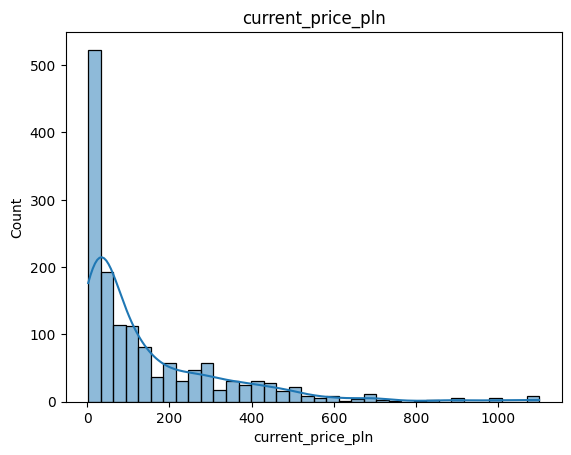

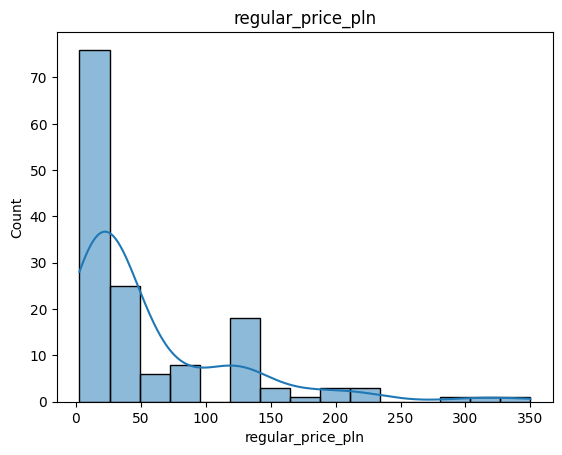

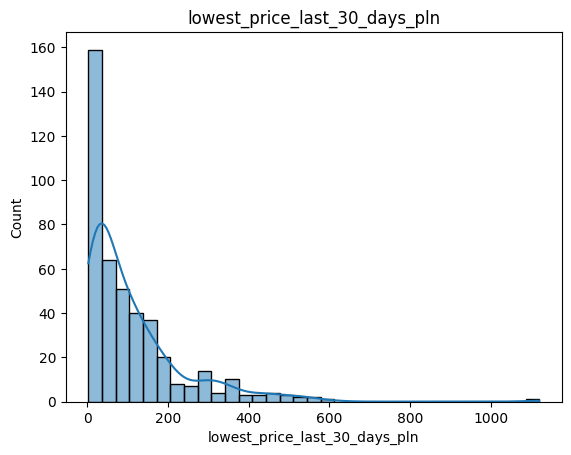

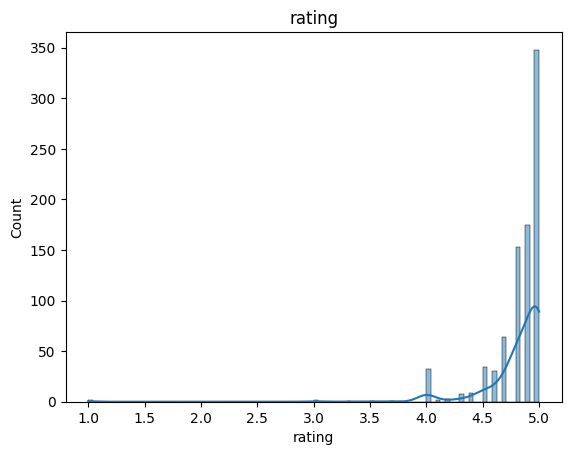

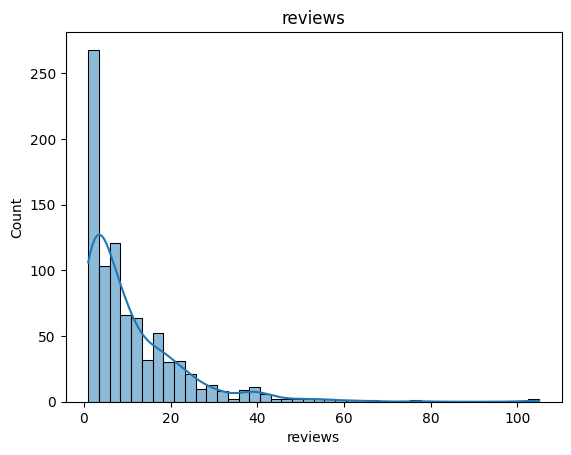

In [85]:
column_names = [
    'current_price_pln',
    'regular_price_pln',
    'lowest_price_last_30_days_pln',
    'rating',
    'reviews'
]
numeric_columns = df[column_names].columns

for col in numeric_columns:
    sns.histplot(df[col], kde = True)
    plt.title(col)
    plt.show()

#### Boxploty

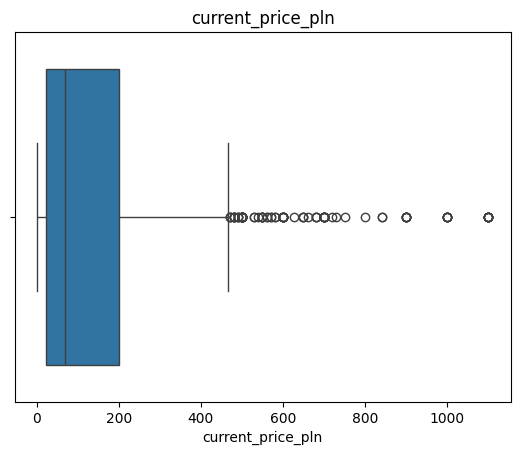

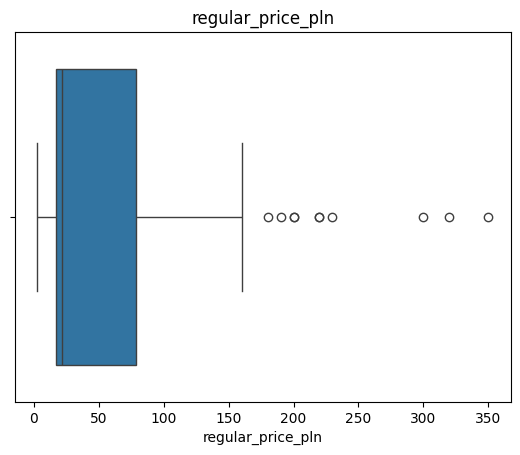

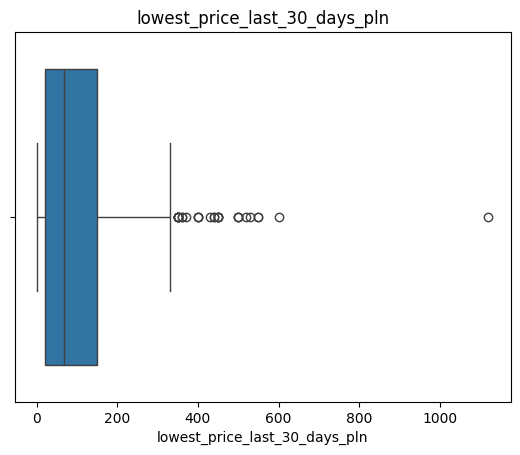

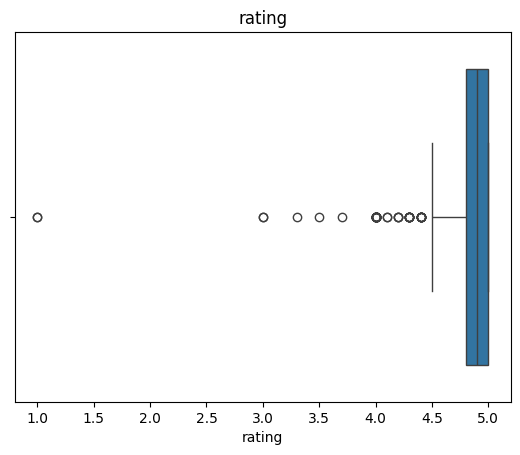

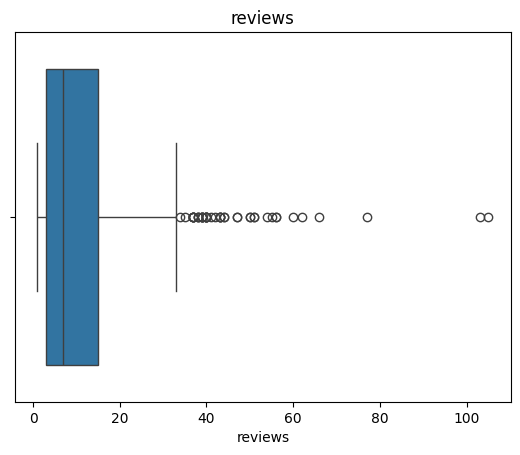

In [86]:
for col in numeric_columns:
    sns.boxplot(data = df, x = col)
    plt.title(col)
    plt.show()

#### Analiza cen

<Axes: xlabel='discount_pct', ylabel='Count'>

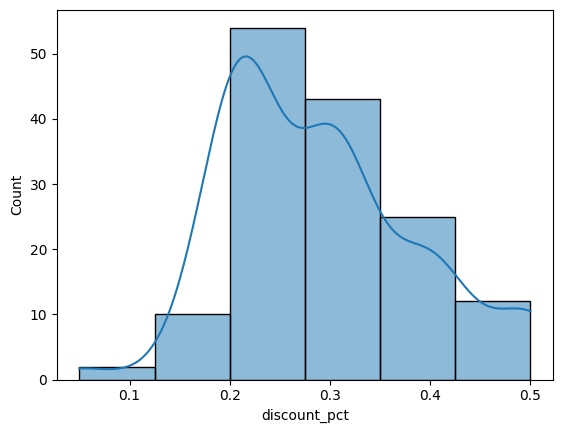

In [87]:
df['discount_pct'] = 1 - (df['current_price_pln'] / df['regular_price_pln'])
# Rozkład zniżek
sns.histplot(df['discount_pct'].dropna(), bins = 6, kde = True)

In [88]:
# Najwyższe przeceny
top_discounts = df.sort_values('discount_pct', ascending = False).head(20)
top_discounts[["name", "discount_pct"]]

,name,discount_pct
764,MEXX Simply,0.500042
330,MEXX Summer Daydream,0.500042
1723,MEXX Black,0.500042
1038,MEXX Whenever Wherever,0.500042
1534,MEXX Man,0.500042
1772,MEXX Ice Touch,0.500042
857,DAVID BECKHAM Classic Homme,0.500031
786,DAVID BECKHAM Classic Blue,0.500031
1406,DAVID BECKHAM Classic,0.500031
352,DAVID BECKHAM Classic Blue,0.488211


In [89]:
# Najwyższej przecenionuye marki
df.groupby("brand", as_index = False)["discount_pct"].mean().sort_values("discount_pct", ascending = False).head(20)

,brand,discount_pct
49,DAVID BECKHAM,0.494121
119,MEXX,0.470277
162,SYOSS,0.423240
96,JOOP!,0.413061
160,STR8,0.400200
138,PEPE JEANS,0.400031
50,DAVIDOFF,0.400020
38,CALVIN KLEIN,0.400020
183,WELEDA,0.368301
155,SCHWARZKOPF,0.360072


<Axes: xlabel='mega_badge', ylabel='discount_pct'>

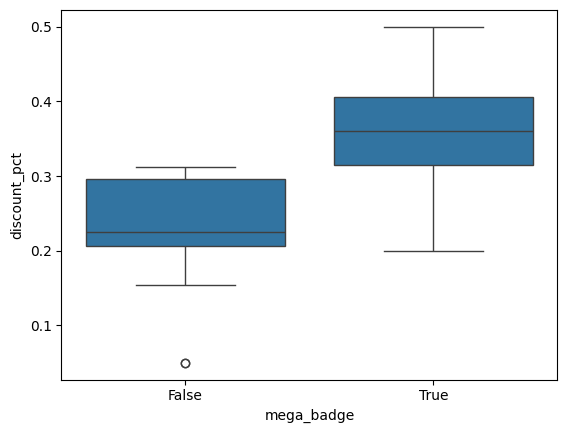

In [90]:
# Czy produkty z odznaką mega mają wyższe promocje?
sns.boxplot(data = df, x = 'mega_badge', y = 'discount_pct')

In [91]:
# Sprawdzenie istotności
with_mega = df[df['mega_badge'] == True]['discount_pct'].dropna()
without_mega = df[df['mega_badge'] == False]['discount_pct'].dropna()

t_stat, p_value = ttest_ind(with_mega, without_mega, equal_var = False)

if p_value < 0.05:
    print(f't-stat: {t_stat:.3f}, p-value: {p_value:.3e}')
    print('Różnica między grupami jest statystycznie istotna.')

t-stat: 9.601, p-value: 7.275e-16
Różnica między grupami jest statystycznie istotna.


#### Analiza marek


In [92]:
# Najpopularniejsze marki
most_popular_brands = df['brand'].value_counts(normalize = True).head(20)
most_popular_brands

brand
NIVEA MEN          0.048583
ISANA              0.036437
ADIDAS             0.035088
HUGO BOSS          0.025641
STR8               0.024291
PACO RABANNE       0.020243
L'ORÉAL            0.019568
BRUNO BANANI       0.018893
OLD SPICE          0.016194
MONT BLANC         0.015520
RITUALS...         0.015520
AA                 0.014845
MASVERI            0.014845
DAVID BECKHAM      0.014845
MEXX               0.014170
NIKE               0.013495
GUERLAIN           0.013495
DOLCE & GABBANA    0.012821
ARMAF              0.012146
POLICE             0.011471
Name: proportion, dtype: float64

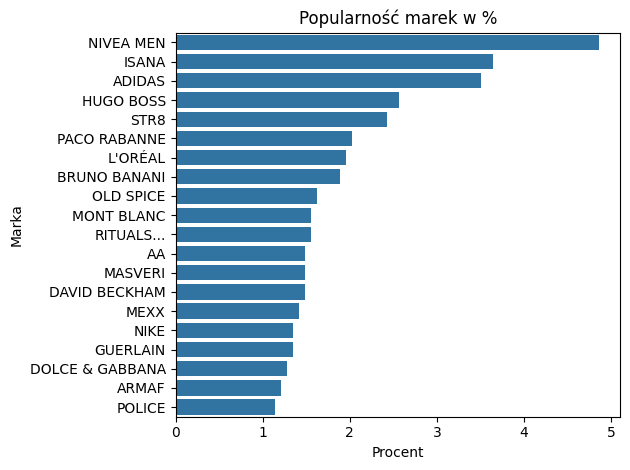

In [93]:
mpb = most_popular_brands.reset_index()
mpb.columns = ['brand', 'value']
mpb['value'] = mpb['value'] * 100

plt.figure()
sns.barplot(x = 'value', y = 'brand', data = mpb)

plt.title('Popularność marek w %')
plt.xlabel('Procent')
plt.ylabel('Marka')

plt.tight_layout()
plt.show()

In [94]:
# Średnie ceny wg. marki
category_avg = df.groupby('brand')['current_price_pln'].mean().sort_values()

# 20 najtańszych marek
category_avg.head(20)

brand
WARS                        4.990000
LIDER                       5.990000
BIAŁY                       7.990000
ZIAJA                       8.204286
FUSSWOHL                    8.404286
ISANA                       9.625185
NO36                        9.823333
FARMONA RADICAL             9.990000
LE PETIT MARSEILLAIS        9.990000
JOANNA                     10.302500
CLEANHANDS                 10.490000
FARMONA NIVELAZIONE        11.490000
SCHAUMA                    13.990000
ALTERRA                    14.365000
SYOSS MEN                  14.990000
SYOSS                      14.990000
4ACTIVE MEN                15.490000
DELIA COSMETICS CAMELEO    16.323333
EVELINE COSMETICS          16.990000
SO!FLOW BY VIS PLANTIS     16.990000
Name: current_price_pln, dtype: float64

In [95]:
# 20 najdroższych marek
category_avg.tail(20)

brand
MONCLER                389.990000
GISADA                 394.390000
GIORGIO ARMANI         416.656667
GUCCI                  418.561429
YVES SAINT LAURENT     426.240000
VIKTOR & ROLF          434.990000
MAISON MARGIELA        439.990000
PACO RABANNE           445.656667
CAROLINA HERRERA       489.107647
ACQUA DI PARMA         496.656667
JEAN PAUL GAULTIER     498.656667
CARTIER                499.990000
HERMES H24             503.323333
RABANNE                543.323333
BVLGARI                556.656667
XERJOFF                561.990000
TOM FORD               571.990000
PARFUMS DE MARLY       947.490000
CREED                  999.990000
AMOUAGE               1033.323333
Name: current_price_pln, dtype: float64

In [116]:
cols = ['cat_4', 'cat_3', 'cat_2']
df[cols] = df[cols].replace('', pd.NA)

df['top_level_category'] = df['cat_4'].combine_first(df['cat_3']).combine_first(df['cat_2'])
df['top_level_category'].value_counts()

top_level_category
Wody toaletowe                      495
Wody perfumowane                    248
Pielęgnacja twarzy                   70
Antyperspiranty                      62
Zestawy zapachowe                    60
Dezodoranty                          46
Żele pod prysznic                    45
Żele i pianki pod prysznic           41
Antyperspiranty do ciała             34
Pianki i kremy do golenia            29
Dezodoranty perfumowane              28
Szampony w płynie                    26
Dezodoranty do ciała                 24
Dezodoranty i zasypki do stóp        23
Gumy, pomady i glinki do włosów      22
Wody po goleniu                      21
Balsamy i kremy po goleniu           21
Oczyszczanie twarzy                  20
Ekstrakty perfum                     18
Szampony i odżywki                   16
Balsamy i olejki do brody            16
Serum i wcierki do skóry głowy       13
Balsamy i żele po goleniu            11
Koloryzacja włosów i zarostu          9
Szampony do brody    

In [117]:
# Marki i ich średnie ceny w kategorii Żele pod prysznic
df[df['top_level_category'] == 'Żele pod prysznic'].groupby('brand')['current_price_pln'].mean().sort_values()


brand
ISANA          7.015000
NIVEA MEN     12.656667
ALTERRA       14.990000
MASVERI       15.490000
STR8          15.990000
ADIDAS        16.656667
AXE           18.990000
PALMOLIVE     19.790000
YOPE          19.990000
LAQ           21.990000
WELEDA        21.990000
HAGI          27.490000
OLD SPICE     32.990000
RITUALS...    47.365000
PHLOV         49.990000
Name: current_price_pln, dtype: float64

In [118]:
# Marki i ich średnie ceny w kategorii Wody perfumowane
df[df['top_level_category'] == 'Wody perfumowane'].groupby('brand')['current_price_pln'].mean().sort_values()


brand
ADOPT'                         47.490000
ARTISCENT                      49.990000
PEPE JEANS                     68.990000
LOU DE PRE                     79.990000
ADIDAS                         87.275714
MEXX                           89.990000
BERANI                         99.990000
JAGUAR                        104.990000
UNITED COLORS OF BENETTON     116.990000
BENTLEY                       119.990000
SORVELLA                      119.990000
AJMAL                         119.990000
BRUNO BANANI                  121.656667
BOUCHERON                     134.990000
LATTAFA                       143.740000
LALIQUE                       149.990000
DAVID BECKHAM                 150.406667
CHOPIN                        154.990000
GUY LAROCHE                   154.990000
BANDERAS                      156.323333
ABERCROMBIE & FITCH           159.990000
ARMAF                         167.323333
ROCHAS                        169.990000
AFNAN                         169.990000
CERRUTI 18

In [99]:
# Marki i ich średnie ceny w kategorii Antyperspiranty
df[df['top_level_category'] == 'Antyperspiranty'].groupby('brand')['current_price_pln'].mean().sort_values()

brand
ISANA                       5.990000
ADIDAS                     11.190000
BEVERLY HILLS POLO CLUB    11.490000
AA                         14.490000
NIVEA MEN                  16.853636
GARNIER MINERAL            17.990000
GARNIER                    17.990000
DOVE                       18.990000
L'ORÉAL                    19.540000
OLD SPICE                  21.990000
REXONA MEN                 21.990000
GILLETTE                   25.990000
TRIPLE DRY                 25.990000
Name: current_price_pln, dtype: float64

#### Analiza kategorii


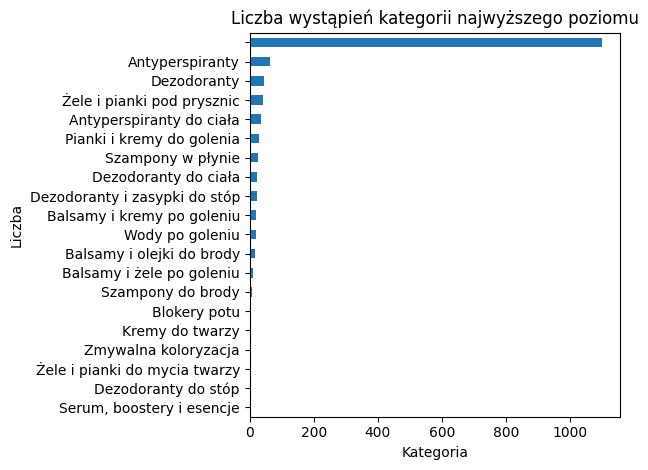

In [100]:
top_10 = df['top_level_category'].value_counts().head(20).iloc[::-1] # odwrócenie wartości - najwyższe na górze
top_10.plot(kind = 'barh')
plt.title('Liczba wystąpień kategorii najwyższego poziomu')
plt.xlabel('Kategoria')
plt.ylabel('Liczba')
plt.tight_layout()
plt.show()

In [101]:
# Średnie ceny wg. kategorii
category_avg = df.groupby('top_level_category')['current_price_pln'].mean().sort_values()
category_avg

top_level_category
Dezodoranty do stóp                8.740000
Spraye i mgiełki do włosów         9.990000
Żele i pianki pod prysznic        13.843659
Pianki i kremy do golenia         14.731379
Dezodoranty i zasypki do stóp     15.616087
Dezodoranty                       16.648696
Antyperspiranty                   17.756129
Szampony do brody                 20.347143
Antyperspiranty do ciała          20.828235
Balsamy i kremy po goleniu        21.775714
Peelingi do twarzy                23.990000
Zmywalna koloryzacja              24.990000
Szampony w płynie                 25.232308
Kremy do twarzy                   26.990000
Wody po goleniu                   30.228095
Blokery potu                      30.590000
Żele i pianki do mycia twarzy     30.656667
Dezodoranty do ciała              31.365000
Balsamy i olejki do brody         34.490000
Balsamy i żele po goleniu         37.762727
Serum, boostery i esencje         87.990000
                                 193.404364
Name: current